In [1]:
import dolfin as df
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import meshio
import xml.etree.ElementTree as ET
import numpy as np
import os
sol_path = "output/sol/"

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Class definition 

In [3]:
class File:
    def __init__(self):
        self.problem = None
        self.alpha_g = None
        self.nS_0S = None
        self.kF_0S = None
        self.gammaFR = None
        self.e_modulus = None
        self.poisson = None
        self.rhoSR = None
        self.rhoFR = None
        self.hatrhoS = None
        self.T_end = None
        self.output_interval = None
        self.dt = None
        self.growth_time = None
        self.path = None

    def load_file(self, file: str):
        last_dot_index = file.rfind(".")
        name = file[:last_dot_index]
        info = name.split("_")
        self.problem = info[0]
        self.alpha_g = info[1]
        self.nS_0S = info[2]
        self.kF_0S = info[3]
        self.gammaFR = info[4]
        self.e_modulus = info[5]
        self.poisson = info[6]
        self.rhoSR = info[7]
        self.rhoFR = info[8]
        self.hatrhoS = info[9]
        self.T_end = info[10]
        self.output_interval = info[11]
        self.dt = info[12]
        self.growth_time = info[13]
        self.bound = info[14]
        self.path = file

In [4]:
class PostProcessor:
    def __init__(self):
        self.mesh = df.Mesh
        self.CG1_sca = None
        self.CG1_vec = None
        self.CG1_ten = None

    def find_key_in_timeseries(self, file: str, group: str, key: str) -> str:
        tree = ET.parse(file)
        root = tree.getroot()
        for grid in root.findall(".//Grid"):
            groups = grid.find(group)
            if groups is not None:
                value = groups.get(key)
                return value

    def get_cell_type(self, file: str) -> str:
        return self.find_key_in_timeseries(file, "Topology", "TopologyType").lower()

    def get_dim(self, file: str) -> int:
        if self.find_key_in_timeseries(file, "Geometry", "GeometryType") == 'XY':
            return 2
        if self.find_key_in_timeseries(file, "Geometry", "GeometryType") == 'XYZ':
            return 3

    def init_function_spaces(self):
        self.CG1_sca = df.FunctionSpace(self.mesh, "CG", 1)
        self.CG1_vec = df.VectorFunctionSpace(self.mesh, "CG", 1)
        self.CG1_ten = df.TensorFunctionSpace(self.mesh, "CG", 1)

    def load_mesh(self, file: str) -> None:
        with meshio.xdmf.TimeSeriesReader(file) as reader:
            points, cells = reader.read_points_cells()
        mesh = df.Mesh()
        editor = df.MeshEditor()
        editor.open(mesh, self.get_cell_type(file), self.get_dim(file), self.get_dim(file))
        editor.init_vertices(len(points))
        editor.init_cells(len(cells[0].data))
        for i, node in enumerate(points):
            editor.add_vertex(i, node)
        for i, element in enumerate(cells[0].data):
            editor.add_cell(i, element)
        editor.close()
        self.mesh = mesh
        self.init_function_spaces()

    def load_timesteps(self, file: str) -> list:
        """
        Loads timesteps from a given XDMF file. Returns list of results in a list of timesteps. Each timestep is a tuple
        of solution time, dictionary of nodal fields and dictionary of cell fields.
        """
        with meshio.xdmf.TimeSeriesReader(file) as reader:
            reader.read_points_cells()
            timesteps = []
            for k in range(reader.num_steps):
                timesteps.append(reader.read_data(k))
        return timesteps

    def map_field(self, val_list, V):
        field_new = df.Function(V)
        for i, val in enumerate(val_list):
            field_new.vector()[df.vertex_to_dof_map(V)[i]] = val
        return field_new

    def def_path(self, *points, resolution=None) -> list:
        """
            Interpolates coordinates between given points with a defined resolution.

            Parameters:
                *points (tuple): Coordinates of the given points. Each point should be a tuple (x, y) for 2D or (x, y, z) for 3D.
                resolution (int): Number of points to interpolate between each pair of consecutive points.

            Returns:
                list: List of interpolated coordinates [(x1, y1, z1), ..., (xn, yn, zn)].
            """
        interpolated_coordinates = []

        for i in range(len(points) - 1):
            start_point = points[i]
            end_point = points[i + 1]

            # Calculate step size for each dimension
            step = [(end - start) / (resolution + 1) for start, end in zip(start_point, end_point)]

            # Include the start point
            interpolated_coordinates.append(start_point)

            # Interpolate coordinates between the given points
            for j in range(resolution):
                interpolated_point = tuple(start + step_size * (j + 1) for start, step_size in zip(start_point, step))
                interpolated_coordinates.append(interpolated_point)

            # Include the end point
        interpolated_coordinates.append(points[-1])

        return interpolated_coordinates

    def get_field_values(self, field: df.Function, coordinates: list) -> list:
        vals = []
        for vertex in coordinates:
            try:
                vals.append(field(vertex))
            except:
                vals.append(0.0)
        return vals

    def get_coordinate_id(self, file, coordinate: tuple):
        coordinate = np.array(coordinate)
        with meshio.xdmf.TimeSeriesReader(file.path) as reader:
            points, cells = reader.read_points_cells()
        for i, point in enumerate(points):
            if np.array_equal(point, coordinate):
                return i

    def field_over_path(self, field: str, file: File, time: int, path: list):
        ts = pp.load_timesteps(file.path)
        if time >= len(ts):
            field_sol = self.map_field(ts[-1][1].get(field), self.CG1_sca)
        else:
            field_sol = pp.map_field(ts[time][1].get(field), self.CG1_sca)

        return self.get_field_values(field_sol, path)

    def field_over_path_ten(self, field: str, file: File, time: int, path: list):
        ts = pp.load_timesteps(file.path)
        if time >= len(ts):
            res = ts[-1][1].get(field)
        else:
            res = ts[time][1].get(field)
        
        sols = []

        for entry in res:
            sols.append(entry[0])
            sols.append(entry[1])
            sols.append(entry[3])
            sols.append(entry[4])

        field_new = df.Function(pp.CG1_ten)

        for i, val in enumerate(sols):
            field_new.vector()[df.vertex_to_dof_map(pp.CG1_ten)[i]] = val

        return pp.get_field_values(field_new, path)

    def field_over_time(self, field: str, file: File, coordinate: tuple, time_interval: list):
        coordinate_id = self.get_coordinate_id(file, coordinate)
        ts = self.load_timesteps(file.path)
        sols = []
        for step in ts:
            sols.append((float(step[0]), float(step[1].get(field)[coordinate_id][0])))
        values = []
        i = 0
        for t_step in time_interval:
            # If the time step is beyond the range of time_value_tuples
            if t_step > sols[-1][0]:
                values.append(sols[-1][1])
                continue

            while i < len(sols) - 1 and t_step > sols[i + 1][0]:
                i += 1

            if i < len(sols) - 1:
                t1, v1 = sols[i]
                t2, v2 = sols[i + 1]
                interpolated_value = v1 + (v2 - v1) * ((t_step - t1) / (t2 - t1))
                values.append(interpolated_value)
            else:
                values.append(sols[i][1])
        return values

# Function definitions

In [5]:
def pressure(file: File, time):
    e_mod = float(f.e_modulus)
    nu = float(f.poisson)
    rhoSR = float(f.rhoSR)
    rhoFR = float(f.rhoFR)
    lambdaS = e_mod * nu / ((1 + nu) * (1 - 2 * nu))  # N/m^2
    muS = e_mod * 1 / (2 * (1 + nu))  # N/m^2
    dens_term = 1 - rhoSR / rhoFR
    hat_term = float(file.hatrhoS) / rhoSR * dens_term
    new_hat = (1 - float(f.alpha_g)) * hat_term
    return np.exp(- new_hat * time) * (2 * muS * (np.exp(new_hat * time) - 1) + 3 * lambdaS * new_hat * time)

def analytical_solution(file: File, time):
    nS_0S = float(file.nS_0S)
    rhoSR = float(file.rhoSR)
    rhoFR = float(file.rhoFR)
    hatnS = float(file.hatrhoS) / rhoSR
    t = time

    dens_term = 1 - rhoSR / rhoFR
    hat_term = hatnS * dens_term
    nS = (nS_0S - 1 / dens_term) * np.exp(-hat_term * t) + 1 / dens_term
    u_S = np.exp(0.5 * hat_term * t) - 1
    p = pressure(file, t)
    return u_S, p, nS

def get_varying_params(list_files):
    varying_params = []
    for attr in [attr for attr in dir(list_files[0]) if not attr.startswith('__') and not attr.startswith("path") and not attr.startswith("load_file")]:
        values = {getattr(file, attr) for file in list_files}
        if len(values) > 1:
            varying_params.append(attr)
    return varying_params

def find_threshold_index(lst, threshold):
    for index, value in enumerate(lst):
        if value >= threshold:
            return index
    return None

# Analytical solution 

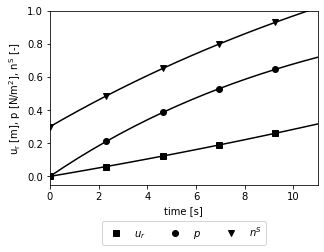

In [6]:
f = File()
f.nS_0S = 0.3
f.rhoSR = 1
f.rhoFR = 2
f.hatrhoS = 0.1
f.e_modulus = 1
f.poisson = 0.25
f.alpha_g = 0
t = np.linspace(0, 11, 20)

fig, ax = plt.subplots()
ax.plot(t, analytical_solution(f, t)[0], color="black")
ax.plot(t[::4], analytical_solution(f, t)[0][::4], linestyle='',marker='s', color="black", label=r'$u_r$')
ax.plot(t, analytical_solution(f, t)[1],color="black")
ax.plot(t[::4], analytical_solution(f, t)[1][::4], linestyle='', marker='o', color="black", label =r'$p$')
ax.plot(t, analytical_solution(f, t)[2],color="black")
ax.plot(t[::4], analytical_solution(f, t)[2][::4], linestyle='', marker='v', color="black", label = r'$n^S$')
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.25,box.width * 0.8, box.height * 0.8])
ax.legend( loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(r'$\mathrm{u}_{\mathrm{r}}$ [m], p [N/m$^2$], $\mathrm{n}^{\mathrm{S}}$ [-]')
plt.xlim(0, 11)
plt.ylim(-0.05, 1.0)
plt.savefig(sol_path + 'analytical_solution.png', dpi=600)
#plt.close()

## Variation of $\alpha_g$ for pressure

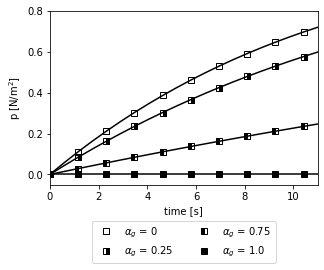

In [7]:
alpha_g = [0.0, 0.25, 0.75, 1.00]

fig, ax = plt.subplots()
marker = ['s', 's', 's', 's']
fill = ['none', 'right', 'left', 'full']

f.alpha_g = 0
ax.plot(t, pressure(f, t), color="black" )
ax.plot(t[::2], pressure(f, t)[::2], color='black', linestyle='', marker=marker[0],fillstyle=fill[0], label= r"$\alpha_g$ = 0"  )

f.alpha_g = 0.25
ax.plot(t, pressure(f, t), color="black" )
ax.plot(t[::2], pressure(f, t)[::2], color="black", linestyle='',  marker=marker[1],fillstyle=fill[1], label= r"$\alpha_g$ = 0.25 "  )

f.alpha_g = 0.75
ax.plot(t, pressure(f, t), color="black")
ax.plot(t[::2], pressure(f, t)[::2], color="black", linestyle='', marker=marker[2],fillstyle=fill[2], label= r"$\alpha_g$ = 0.75 "  )

f.alpha_g = 1
ax.plot(t, pressure(f, t), color="black" )
ax.plot(t[::2], pressure(f, t)[::2], color="black", linestyle='', marker=marker[3],fillstyle=fill[3], label= r"$\alpha_g$ = 1.0"  )

#ax.set_title(r'Pressure with different $J_{Sg}$')
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.25,box.width * 0.8, box.height * 0.8])
ax.legend( loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=2)
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(r'p [N/m$^2$]')
plt.xlim(0, 11)
plt.ylim(-0.05, 0.8)
plt.savefig(sol_path + 'analytical_var_alpha_g.png', dpi=600)
#plt.close()

# Numerical examples

first collect all results in a list 'files'

In [8]:
files = []
files_in_folder = os.listdir(sol_path)
xdmf_files = [file for file in files_in_folder if file.endswith(".xdmf")]
for file in xdmf_files:
    f = File()
    f.load_file(file)
    f.path = sol_path + os.sep + f.path
    files.append(f)

Limit to Poisson ratio of '0.1' and divide into both examples

In [9]:
files_consol = []
files_tissue = []
for file in files:
    if file.poisson == "0.1" and file.rhoSR == "1":
        if file.problem == "FullCircle":
            files_consol.append(file)
            print(file.path)
        if file.problem == "SplitCircle":
            files_tissue.append(file)
print()
files_consol_outflow = []
for file in files_consol:
    if file.bound=="withOutflow":
        files_consol_outflow.append(file)
        print(file.path)

files_tissue_outflow = []
for file in files_tissue:
    if file.bound=="withOutflow":
        files_tissue_outflow.append(file)

output/sol//FullCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withoutOutflow.xdmf
output/sol//FullCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withOutflow.xdmf
output/sol//FullCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withOutflow.xdmf
output/sol//FullCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withOutflow.xdmf
output/sol//FullCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withoutOutflow.xdmf
output/sol//FullCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withoutOutflow.xdmf

output/sol//FullCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withOutflow.xdmf
output/sol//FullCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withOutflow.xdmf
output/sol//FullCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_300_1_1_50_withOutflow.xdmf


## Consolidation example

load post processor and mesh of first example. Print fields and varying parameters in the list of files. 

In [10]:
pp = PostProcessor()
pp.load_mesh(files_consol[0].path)
#print(list(pp.load_timesteps(files_consol[0].path)[0][1].keys()))

### Displacement

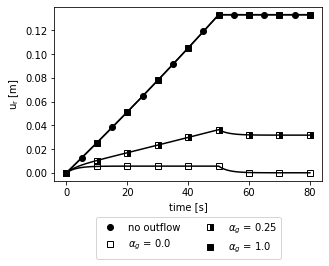

In [11]:
attribute = "u_r"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
file_name = "homo_" + attribute + "_time.png"
coordinates = (1,0)
t = np.linspace(0, 80, 81)

vals_consol_u = []
for file in files_consol:
    vals_consol_u.append(pp.field_over_time(attribute, file, coordinates, t))
    
fig, ax = plt.subplots()

ax.plot(t, vals_consol_u[0], color="black", label="_no_legend_")
ax.plot(t[::5], vals_consol_u[0][::5], linestyle="", color="black", marker='o', label= "no outflow")

ax.plot(t, vals_consol_u[2], color="black", label="_no_legend_")
ax.plot(t[::10], vals_consol_u[2][::10], linestyle="", color="black", marker='s', fillstyle="none", label= r"$\alpha_g$ = " + files_consol[2].alpha_g)

ax.plot(t, vals_consol_u[1], color="black", label="_no_legend_")
ax.plot(t[::10], vals_consol_u[1][::10], linestyle="", color="black", marker='s', fillstyle="right", label= r"$\alpha_g$ = " + files_consol[1].alpha_g)

ax.plot(t, vals_consol_u[3], color="black", label="_no_legend_")
ax.plot(t[::10], vals_consol_u[3][::10], linestyle="", color="black", marker='s', fillstyle="full", label= r"$\alpha_g$ = " + files_consol[3].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.25,box.width * 0.8, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=2)
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + file_name, dpi=600)
#plt.close()

### Volume fraction

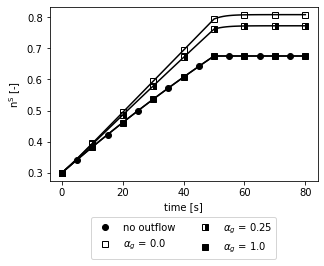

In [12]:
attribute = "nS"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
file_name = "homo_" + attribute + "_time.png"
coordinates = (0,0)
t = np.linspace(0, 80, 81)

vals_consol_nS = []
for file in files_consol:
    vals_consol_nS.append(pp.field_over_time(attribute, file, coordinates, t))
    
fig, ax = plt.subplots()
ax.plot(t, vals_consol_nS[0], color="black", label="_no_legend_")
ax.plot(t[::5], vals_consol_nS[0][::5], linestyle="", color="black", marker='o', label= "no outflow")

ax.plot(t, vals_consol_nS[2], color="black", label="_no_legend_")
ax.plot(t[::10], vals_consol_nS[2][::10], linestyle="", color="black", marker='s', fillstyle="none", label= r"$\alpha_g$ = " + files_consol[2].alpha_g)

ax.plot(t, vals_consol_nS[1], color="black", label="_no_legend_")
ax.plot(t[::10], vals_consol_nS[1][::10], linestyle="", color="black", marker='s', fillstyle="right", label= r"$\alpha_g$ = " + files_consol[1].alpha_g)

ax.plot(t, vals_consol_nS[3], color="black", label="_no_legend_")
ax.plot(t[::10], vals_consol_nS[3][::10], linestyle="", color="black", marker='s', fillstyle="full", label= r"$\alpha_g$ = " + files_consol[3].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.8, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=2)
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + file_name, dpi=600)
#plt.close()

### Pressure

In [13]:
attribute = "p"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
points_2d = [(0, 0), (1, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
times = [50, 80]

sol_consol_p_path = []
for file in files_consol_outflow:
    for time in times:
        print(file.alpha_g, time)
        sol_consol_p_path.append(pp.field_over_path(attribute, file, time, coordinates))

0.25 50
0.25 80
0.0 50
0.0 80
1.0 50
1.0 80


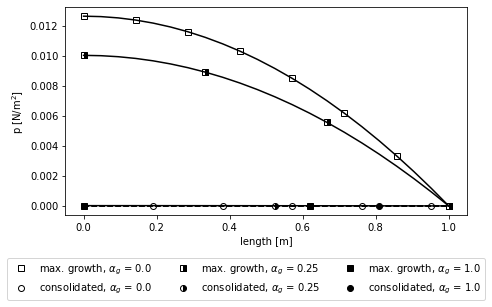

In [14]:
fig, ax = plt.subplots(figsize=(8,4.8))
    
ax.plot(lengths, sol_consol_p_path[2], color="black", label="_no_legend_")
ax.plot(lengths[::3], sol_consol_p_path[2][::3], linestyle="", color="black", marker='s', fillstyle="none", label="max. growth"  
        + r", $\alpha_g$ = " + files_consol_outflow[1].alpha_g) 

ax.plot(lengths, sol_consol_p_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_consol_p_path[3][::4], linestyle="", color="black", marker='o', fillstyle="none", label="consolidated"  
        + r", $\alpha_g$ = " + files_consol_outflow[1].alpha_g) 

ax.plot(lengths, sol_consol_p_path[0], color="black", label="_no_legend_")
ax.plot(lengths[::7], sol_consol_p_path[0][::7], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth" 
        + r", $\alpha_g$ = " + files_consol_outflow[0].alpha_g)

ax.plot(lengths, sol_consol_p_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::11], sol_consol_p_path[1][::11], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
        + r", $\alpha_g$ = " + files_consol_outflow[0].alpha_g)

ax.plot(lengths, sol_consol_p_path[4], color="black", label="_no_legend_")
ax.plot(lengths[::13], sol_consol_p_path[4][::13], linestyle="", color="black", marker='s',fillstyle="full", label="max. growth"  
        + r", $\alpha_g$ = " + files_consol_outflow[2].alpha_g)  

ax.plot(lengths, sol_consol_p_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::17], sol_consol_p_path[5][::17], linestyle="", color="black", marker='o',fillstyle="full", label="consolidated"  
        + r", $\alpha_g$ = " + files_consol_outflow[2].alpha_g)  
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + "homo_p_path.png", dpi=600)
#plt.close()

### Extra stress

In [15]:
attribute = "extra stress"
points_2d = [(0, 0), (1, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
times = [50, 80]

sol_consol_stress_path = []
for file in files_consol_outflow:
    for time in times:
        print(file.alpha_g, time)
        sol_consol_stress_path.append([arr[0] for arr in pp.field_over_path_ten(attribute, file, time, coordinates)])

0.25 50
0.25 80
0.0 50
0.0 80
1.0 50
1.0 80


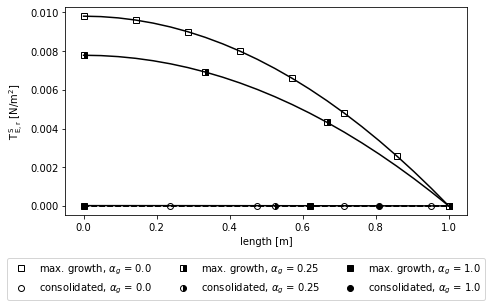

In [16]:
fig, ax = plt.subplots(figsize=(8,4.8))

ax.plot(lengths, sol_consol_stress_path[2], color="black", label="_no_legend_")
ax.plot(lengths[::3], sol_consol_stress_path[2][::3], linestyle="", color="black", marker='s', fillstyle = "none", label="max. growth"  
        + r", $\alpha_g$ = " + files_consol_outflow[1].alpha_g)

ax.plot(lengths, sol_consol_stress_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::5], sol_consol_stress_path[3][::5], linestyle="", color="black", marker='o', fillstyle = "none", label="consolidated"  
        + r", $\alpha_g$ = " + files_consol_outflow[1].alpha_g)


ax.plot(lengths, sol_consol_stress_path[0], linestyle="-", color="black", label="_no_legend_")
ax.plot(lengths[::7], sol_consol_stress_path[0][::7], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
        + r", $\alpha_g$ = " + files_consol_outflow[0].alpha_g)

ax.plot(lengths, sol_consol_stress_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::11], sol_consol_stress_path[1][::11], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
        + r", $\alpha_g$ = " + files_consol_outflow[0].alpha_g)


ax.plot(lengths, sol_consol_stress_path[4], linestyle="-", color="black", label="_no_legend_")
ax.plot(lengths[::13], sol_consol_stress_path[4][::13], linestyle="", color="black", marker='s',fillstyle="full", label="max. growth"  
        + r", $\alpha_g$ = " + files_consol_outflow[2].alpha_g)

ax.plot(lengths, sol_consol_stress_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::17], sol_consol_stress_path[5][::17], linestyle="", color="black", marker='o',fillstyle="full", label="consolidated" 
        + r", $\alpha_g$ = " + files_consol_outflow[2].alpha_g)


box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(r"$\mathrm{T}^{\,\mathrm{S}}_{\,\mathrm{E,r}}$ [N/m$^2$]")
plt.savefig(sol_path + "homo_T_S_E_path_all.png", dpi=600)
#plt.close()

## Embedding in surrounding tissue

In [17]:
pp = PostProcessor()
pp.load_mesh(files_tissue[0].path)
#print(list(pp.load_timesteps(files_tissue[0].path)[0][1].keys()))

In [18]:
for file in files_tissue_outflow:
        ts = pp.load_timesteps(file.path)
        print(os.path.basename(file.alpha_g), " ", len(ts))

0.0   618
1.0   522
0.25   605


## Displacements

In [19]:
attribute = "u_r"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
file_name = "hetero_" + attribute + "_time.png"

coordinate = (1,0)
t = np.linspace(0, 500, 501)

vals_tissue_u = []
for file in files_tissue_outflow:
    print(file.path)
    vals_tissue_u.append(pp.field_over_time(attribute, file, coordinate, t))

output/sol//SplitCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf


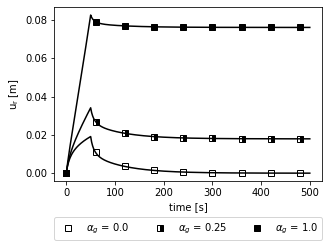

In [20]:
fig, ax = plt.subplots()

ax.plot(t, vals_tissue_u[0], color="black", label="_no_legend_")
ax.plot(t[:500:60], vals_tissue_u[0][:500:60], linestyle="", color="black", marker='s',fillstyle="none", label= r"$\alpha_g$ = " + files_tissue_outflow[0].alpha_g)

ax.plot(t, vals_tissue_u[2], color="black", label="_no_legend_")
ax.plot(t[:500:60], vals_tissue_u[2][:500:60], linestyle="", color="black", marker='s',fillstyle="right", label= r"$\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(t, vals_tissue_u[1], color="black", label="_no_legend_")
ax.plot(t[:500:60], vals_tissue_u[1][:500:60], linestyle="", color="black", marker='s', label= r"$\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.15,box.width * 0.8, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=3)
#ax.legend()
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + file_name, dpi=600)
#plt.close()

In [21]:
attribute = "u_r"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
file_name = "hetero_relaxation_" + attribute + "_timeplot_poisson=0.1_alpha_g.png"
points_2d = [(0, 0), (5, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
times = [50, 700]

sol_tissue_u_path = []
for file in files_tissue_outflow:
    print(file.path, file.alpha_g)
    for time in times:
        sol_tissue_u_path.append(pp.field_over_path(attribute, file, time, coordinates))

output/sol//SplitCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf 0.0
output/sol//SplitCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf 1.0
output/sol//SplitCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf 0.25


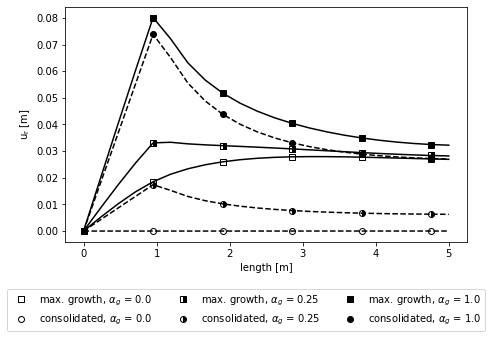

In [22]:
fig, ax = plt.subplots(figsize=(8,4.8))

ax.plot(lengths, sol_tissue_u_path[0], color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_u_path[0][::4], linestyle="", color="black", marker='s',fillstyle="none", label="max. growth" 
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 


ax.plot(lengths, sol_tissue_u_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_u_path[1][::4], linestyle="", color="black", marker='o',fillstyle="none", label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g)


ax.plot(lengths, sol_tissue_u_path[4], color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_u_path[4][::4], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth" 
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)


ax.plot(lengths, sol_tissue_u_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_u_path[5][::4], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)


ax.plot(lengths, sol_tissue_u_path[2], color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_u_path[2][::4], linestyle="", color="black", marker='s', label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)


ax.plot(lengths, sol_tissue_u_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_u_path[3][::4], linestyle="", color="black", marker='o', label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.9])
#ax.set_position([box.x0 + box.width * 0.2, box.y0 + box.height * 0.35,box.width * 0.8, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + "hetero_u_r_path.png", dpi=600)
#plt.close()

## Volume fraction

Position (1.0, 0.0)

In [23]:
attribute = "nS"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
attr_title = {"u_r": r"Displacements", "p": "Pressure", "nS": "Volume fraction"}

coordinate = (1,0)
t = np.linspace(0, 500, 501)

vals_tissue_nS_1 = []
for file in files_tissue_outflow:
    print(file.path)
    vals_tissue_nS_1.append(pp.field_over_time(attribute, file, coordinate, t))

output/sol//SplitCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf


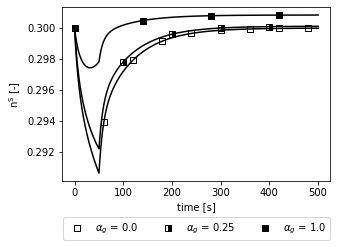

In [24]:
fig, ax = plt.subplots()

ax.plot(t, vals_tissue_nS_1[0], color="black", label="_no_legend_")
ax.plot(t[:500:20*3], vals_tissue_nS_1[0][:500:20*3], linestyle="", color="black", marker='s',fillstyle="none", 
        label= r"$\alpha_g$ = " + files_tissue_outflow[0].alpha_g)

ax.plot(t, vals_tissue_nS_1[2], color="black", label="_no_legend_")
ax.plot(t[:500:20*5], vals_tissue_nS_1[2][:500:20*5], linestyle="", color="black", marker='s',fillstyle="right", 
        label= r"$\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(t, vals_tissue_nS_1[1], color="black", label="_no_legend_")
ax.plot(t[:500:20*7], vals_tissue_nS_1[1][:500:20*7], linestyle="", color="black", marker='s', 
        label= r"$\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.15,box.width * 0.8, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=3)
#ax.legend()
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + "hetero_1_0_nS_time.png", dpi=600)
#plt.close()

Position (0.0, 0.0)

In [25]:
attribute = "nS"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}

coordinate = (0,0)
t = np.linspace(0, 500, 501)


vals_tissue_nS_0 = []
for file in files_tissue_outflow:
    print(file.path)
    vals_tissue_nS_0.append(pp.field_over_time(attribute, file, coordinate, t))

output/sol//SplitCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf


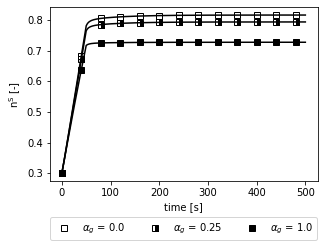

In [26]:
fig, ax = plt.subplots()

ax.plot(t, vals_tissue_nS_0[0], color="black", label="_no_legend_")
ax.plot(t[::40], vals_tissue_nS_0[0][::40], linestyle="", color="black", marker='s',fillstyle="none", label= r"$\alpha_g$ = " + files_tissue_outflow[0].alpha_g)

ax.plot(t, vals_tissue_nS_0[2], color="black", label="_no_legend_")
ax.plot(t[::40], vals_tissue_nS_0[2][::40], linestyle="", color="black", marker='s',fillstyle="right", label= r"$\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(t, vals_tissue_nS_0[1], color="black", label="_no_legend_")
ax.plot(t[::40], vals_tissue_nS_0[1][::40], linestyle="", color="black", marker='s', label= r"$\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.15,box.width * 0.8, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + "hetero_0_0_nS_time.png", dpi=600)
#plt.close()

Value over path

In [27]:
attribute = "nS"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
file_name = "hetero_relaxation_" + attribute + "_timeplot_poisson=0.1_alpha_g.png"

points_2d = [(0, 0),(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
idx = find_threshold_index(lengths, 0.99)
times = [50, 700]

sol_tissue_nS_path = []
for file in files_tissue_outflow:
    for time in times:
        print(file.alpha_g, time)
        lst = pp.field_over_path(attribute, file, time, coordinates)
        #if file.alpha_g != "0.0":
        lst[idx] = np.nan
        sol_tissue_nS_path.append(lst)

0.0 50
0.0 700
1.0 50
1.0 700
0.25 50
0.25 700


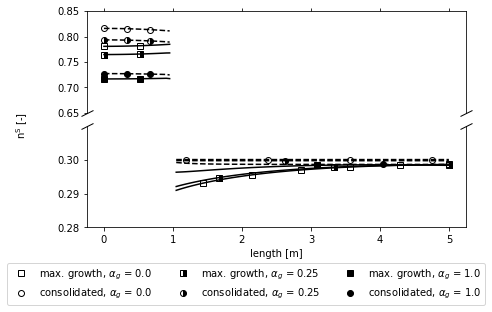

In [28]:
#fig, ax = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,4.8))
fig.subplots_adjust(hspace=0.05)

ax1.plot(lengths, sol_tissue_nS_path[0], color="black", label="_no_legend_")
ax1.plot(lengths[::11], sol_tissue_nS_path[0][::11], linestyle="", color="black", marker='s',fillstyle="none", label="max. growth"  
         + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

ax1.plot(lengths, sol_tissue_nS_path[1], linestyle="--", color="black", label="_no_legend_")
ax1.plot(lengths[::7], sol_tissue_nS_path[1][::7], linestyle="", color="black", marker='o',fillstyle="none", label="consolidated"  
         + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 


ax1.plot(lengths, sol_tissue_nS_path[4], color="black", label="_no_legend_")
ax1.plot(lengths[::11], sol_tissue_nS_path[4][::11], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
         + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax1.plot(lengths, sol_tissue_nS_path[5], linestyle="--", color="black", label="_no_legend_")
ax1.plot(lengths[::7], sol_tissue_nS_path[5][::7], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
         + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)


ax1.plot(lengths, sol_tissue_nS_path[2], color="black", label="_no_legend_")
ax1.plot(lengths[::11], sol_tissue_nS_path[2][::11], linestyle="", color="black", marker='s', label="max. growth"  
         + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

ax1.plot(lengths, sol_tissue_nS_path[3], linestyle="--", color="black", label="_no_legend_")
ax1.plot(lengths[::7], sol_tissue_nS_path[3][::7], linestyle="", color="black", marker='o', label="consolidated"  
         + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

#-------------------------

ax2.plot(lengths, sol_tissue_nS_path[0], color="black", label="_no_legend_")
ax2.plot(lengths[::5*3], sol_tissue_nS_path[0][::5*3], linestyle="", color="black", marker='s',fillstyle="none", label="max. growth"  
         + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

ax2.plot(lengths, sol_tissue_nS_path[1], linestyle="--", color="black", label="_no_legend_")
ax2.plot(lengths[::5*5], sol_tissue_nS_path[1][::5*5], linestyle="", color="black", marker='o',fillstyle="none", label="consolidated"  
         + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

ax2.plot(lengths, sol_tissue_nS_path[4], color="black", label="_no_legend_")
ax2.plot(lengths[::5*7], sol_tissue_nS_path[4][::5*7], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
         + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax2.plot(lengths, sol_tissue_nS_path[5], linestyle="--", color="black", label="_no_legend_")
ax2.plot(lengths[::5*11], sol_tissue_nS_path[5][::5*11], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
         + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax2.plot(lengths, sol_tissue_nS_path[2], color="black", label="_no_legend_")
ax2.plot(lengths[::5*13], sol_tissue_nS_path[2][::5*13], linestyle="", color="black", marker='s', label="max. growth"  
         + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

ax2.plot(lengths, sol_tissue_nS_path[3], linestyle="--", color="black", label="_no_legend_")
ax2.plot(lengths[::5*17], sol_tissue_nS_path[3][::5*17], linestyle="", color="black", marker='o', label="consolidated"  
         + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

ax1.set_ylim(0.65, 0.85)  # outliers only
ax2.set_ylim(0.28, 0.31)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_yticks([0.28, 0.29, 0.30])

box = ax2.get_position()
ax1.set_position([box.x0 + box.width * 0.1, box.y0 + box.height *1.3 ,box.width * 0.85, box.height * 0.8])
ax2.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.4,box.width * 0.85, box.height * 0.8])
ax2.legend(loc='upper center', bbox_to_anchor=(0.42, -0.3), fancybox=True, shadow=False, ncol=3)
ax2.xaxis.set_label_text('length [m]')
ax2.yaxis.set_label_text(attr_legend.get(attribute))
ax2.set_ylabel(attr_legend.get(attribute), labelpad=10, rotation=90, va = 'bottom')
ax2.yaxis.set_label_coords(-0.15, 1)
plt.savefig(sol_path + "hetero_nS_path.png", dpi=600)
#plt.close()

## Pressure

Position (0.0, 0.0)

In [29]:
attribute = "p"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
coordinate = (0,0)
t = np.linspace(0, 500, 501)


vals_tissue_p_0 = []
for file in files_tissue_outflow:
    print(file.path)
    vals_tissue_p_0.append(pp.field_over_time(attribute, file, coordinate, t))

output/sol//SplitCircle_0.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_1.0_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf
output/sol//SplitCircle_0.25_0.3_0.1_1.0_1.0_0.1_1_2_0.01_800_1_1_50_withOutflow.xdmf


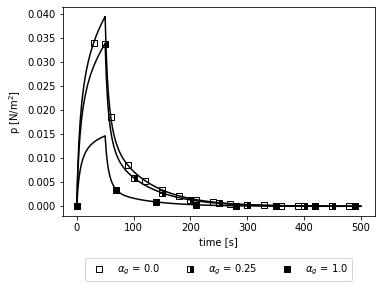

In [30]:
fig, ax = plt.subplots(figsize=(7,4.8))

ax.plot(t, vals_tissue_p_0[0], color="black", label="_no_legend_")
ax.plot(t[:500:10*3], vals_tissue_p_0[0][:500:10*3], linestyle="", color="black", marker='s',fillstyle="none", label= r"$\alpha_g$ = " + files_tissue_outflow[0].alpha_g)

ax.plot(t, vals_tissue_p_0[2], color="black", label="_no_legend_")
ax.plot(t[:500:10*5], vals_tissue_p_0[2][:500:10*5], linestyle="", color="black", marker='s',fillstyle="right", label= r"$\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(t, vals_tissue_p_0[1], color="black", label="_no_legend_")
ax.plot(t[:500:10*7], vals_tissue_p_0[1][:500:10*7], linestyle="", color="black", marker='s', label= r"$\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
   
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.15,box.width * 0.8, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('time [s]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + "hetero_p_time.png", dpi=600)
#plt.close()

Value over path

In [31]:
attribute = "p"
attr_legend = {"u_r": r"$\mathrm{u}_{\mathrm{r}}$ [m]", "p": r"p [N/m$^2$]", "nS": r"$\mathrm{n}^{\mathrm{S}}$ [-]"}
file_name = "hetero_relaxation_" + attribute + "_timeplot_poisson=0.1_alpha_g.png"
points_2d = [(0, 0), (5, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
times = [50, 700]

sol_tissue_p_path = []
for file in files_tissue_outflow:
    for time in times:
        print(file.alpha_g, time)
        sol_tissue_p_path.append(pp.field_over_path(attribute, file, time, coordinates))

0.0 50
0.0 700
1.0 50
1.0 700
0.25 50
0.25 700


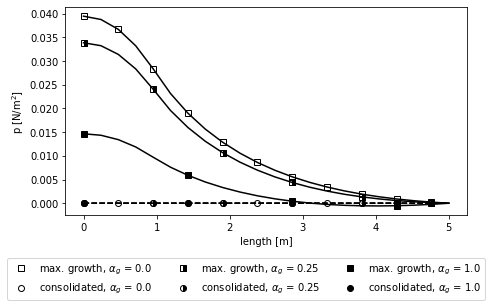

In [32]:
fig, ax = plt.subplots(figsize=(8,4.8))
  
ax.plot(lengths, sol_tissue_p_path[0], color="black", label="_no_legend_")
ax.plot(lengths[::2], sol_tissue_p_path[0][::2], linestyle="", color="black", marker='s',fillstyle="none", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

ax.plot(lengths, sol_tissue_p_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::2], sol_tissue_p_path[1][::2], linestyle="", color="black", marker='o',fillstyle="none", label="consolidated"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 
    
ax.plot(lengths, sol_tissue_p_path[4], color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_p_path[4][::4], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(lengths, sol_tissue_p_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_p_path[5][::4], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated"  
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(lengths, sol_tissue_p_path[2], color="black", label="_no_legend_")
ax.plot(lengths[::6], sol_tissue_p_path[2][::6], linestyle="", color="black", marker='s', label="max. growth" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

ax.plot(lengths, sol_tissue_p_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::6], sol_tissue_p_path[3][::6], linestyle="", color="black", marker='o', label="consolidated"  
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)


box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(attr_legend.get(attribute))
plt.savefig(sol_path + "hetero_p_path.png", dpi=600)

## Jacobian

In [33]:
attribute = "J_S"

points_2d = [(0, 0),(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
orig_lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
idx = find_threshold_index(lengths, 0.99)
times = [50, 700]

sol_tissue_J_S_path = []
for file in files_tissue_outflow:
    for time in times:
        print(file.alpha_g, time)
        lst = pp.field_over_path(attribute, file, time, coordinates)
        if file.alpha_g != "0.0":
            lst[idx] = np.nan
        sol_tissue_J_S_path.append(lst)

0.0 50
0.0 700
1.0 50
1.0 700
0.25 50
0.25 700


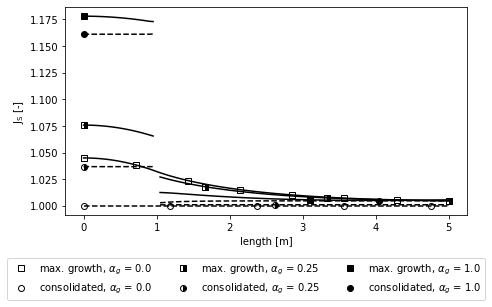

In [34]:
fig, ax = plt.subplots(figsize=(8,4.8))

ax.plot(lengths, sol_tissue_J_S_path[0], color="black", label="_no_legend_")
ax.plot(lengths[::5*3], sol_tissue_J_S_path[0][::5*3], linestyle="", color="black", marker='s',fillstyle="none", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

ax.plot(lengths, sol_tissue_J_S_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::5*5], sol_tissue_J_S_path[1][::5*5], linestyle="", color="black", marker='o',fillstyle="none", label="consolidated"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 


ax.plot(lengths, sol_tissue_J_S_path[4], color="black", label="_no_legend_")
ax.plot(lengths[::5*7], sol_tissue_J_S_path[4][::5*7], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(lengths, sol_tissue_J_S_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::5*11], sol_tissue_J_S_path[5][::5*11], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

   
ax.plot(lengths, sol_tissue_J_S_path[2], color="black", label="_no_legend_")
ax.plot(lengths[::5*13], sol_tissue_J_S_path[2][::5*13], linestyle="", color="black", marker='s', label="max. growth" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

ax.plot(lengths, sol_tissue_J_S_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::5*17], sol_tissue_J_S_path[3][::5*17], linestyle="", color="black", marker='o', label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(r"$\mathrm{J}_{\mathrm{S}}$ [-]")
plt.savefig(sol_path + "hetero_J_S_path.png", dpi=600)
#plt.close()

In [35]:
attribute = "J_SG"

points_2d = [(0, 0),(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
orig_lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
idx = find_threshold_index(lengths, 0.99)
times = [50, 700]

sol_tissue_J_SG_path = []
for file in files_tissue_outflow:
    for time in times:
        print(file.alpha_g, time)
        lst = pp.field_over_path(attribute, file, time, coordinates)
        if file.alpha_g != "0.0":
            lst[idx] = np.nan
        sol_tissue_J_SG_path.append(lst)

0.0 50
0.0 700
1.0 50
1.0 700
0.25 50
0.25 700


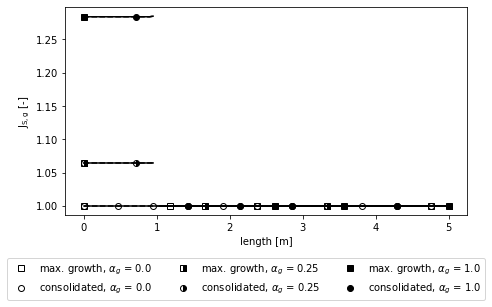

In [36]:
fig, ax = plt.subplots(figsize=(8,4.8))

i_null = 5*5
ax.plot(lengths, sol_tissue_J_SG_path[0], color="black", label="_no_legend_")
ax.plot(lengths[::i_null], sol_tissue_J_SG_path[0][::i_null], linestyle="", color="black", marker='s',fillstyle="none", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 
i_null = 5*2
ax.plot(lengths, sol_tissue_J_SG_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::i_null], sol_tissue_J_SG_path[1][::i_null], linestyle="", color="black", marker='o',fillstyle="none", label="consolidated"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

i_middle = 5*7
ax.plot(lengths, sol_tissue_J_SG_path[4], color="black", label="_no_legend_")
ax.plot(lengths[::i_middle], sol_tissue_J_SG_path[4][::i_middle], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)
i_middle = 5*3
ax.plot(lengths, sol_tissue_J_SG_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::i_middle], sol_tissue_J_SG_path[5][::i_middle], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

i_one  = 5*11
ax.plot(lengths, sol_tissue_J_SG_path[2], color="black", label="_no_legend_")
ax.plot(lengths[::i_one], sol_tissue_J_SG_path[2][::i_one], linestyle="", color="black", marker='s', label="max. growth" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

i_one = 5*3
ax.plot(lengths, sol_tissue_J_SG_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::i_one], sol_tissue_J_SG_path[3][::i_one], linestyle="", color="black", marker='o', label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(r"$\mathrm{J}_{\mathrm{S,g}}$ [-]")
plt.savefig(sol_path + "hetero_J_SG_path.png", dpi=600)
#plt.close()

In [37]:
attribute = "J_SE"

points_2d = [(0, 0),(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
orig_lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
idx = find_threshold_index(lengths, 0.99)
times = [50, 700]

sol_tissue_J_SE_path = []
for file in files_tissue_outflow:
    for time in times:
        print(file.alpha_g, time)
        lst = pp.field_over_path(attribute, file, time, coordinates)
        if file.alpha_g != "0.0":
            lst[idx] = np.nan
        sol_tissue_J_SE_path.append(lst)

0.0 50
0.0 700
1.0 50
1.0 700
0.25 50
0.25 700


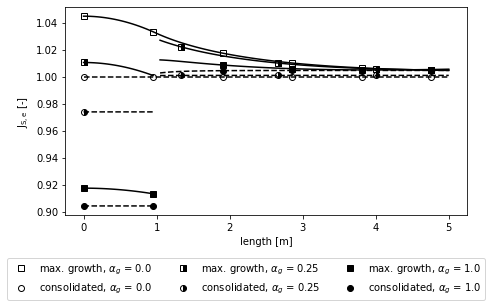

In [38]:
fig, ax = plt.subplots(figsize=(8,4.8))

i_null = 4*5
ax.plot(lengths, sol_tissue_J_SE_path[0], color="black", label="_no_legend_")
ax.plot(lengths[::i_null], sol_tissue_J_SE_path[0][::i_null], linestyle="", color="black", marker='s',fillstyle="none", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

ax.plot(lengths, sol_tissue_J_SE_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::i_null], sol_tissue_J_SE_path[1][::i_null], linestyle="", color="black", marker='o',fillstyle="none", label="consolidated"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g) 

i_middle = 4*7
ax.plot(lengths, sol_tissue_J_SE_path[4], color="black", label="_no_legend_")
ax.plot(lengths[::i_middle], sol_tissue_J_SE_path[4][::i_middle], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(lengths, sol_tissue_J_SE_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::i_middle], sol_tissue_J_SE_path[5][::i_middle], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

i_one = 4*5
ax.plot(lengths, sol_tissue_J_SE_path[2], color="black", label="_no_legend_")
ax.plot(lengths[::i_one], sol_tissue_J_SE_path[2][::i_one], linestyle="", color="black", marker='s', label="max. growth" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

ax.plot(lengths, sol_tissue_J_SE_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::i_one], sol_tissue_J_SE_path[3][::i_one], linestyle="", color="black", marker='o', label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)
    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(r"$\mathrm{J}_{\mathrm{S,e}}$ [-]")
plt.savefig(sol_path + "hetero_J_SE_path.png", dpi=600)
#plt.close()

## Extra stresses

In [39]:
attribute = "extra stress"
attr_legend = {"extra stress": r"$T_{S}$ [m]"}
points_2d = [(0, 0), (5, 0)]
resolution = 20
coordinates = pp.def_path(*points_2d, resolution=resolution)
lengths = [np.sqrt(sum(x ** 2 for x in point)) for point in coordinates]
times = [50, 400]

sol_tissue_stress_path = []
for file in files_tissue_outflow:
    for time in times:
        print(file.alpha_g, time)
        sol_tissue_stress_path.append([arr[0] for arr in pp.field_over_path_ten(attribute, file, time, coordinates)])

0.0 50
0.0 400
1.0 50
1.0 400
0.25 50
0.25 400


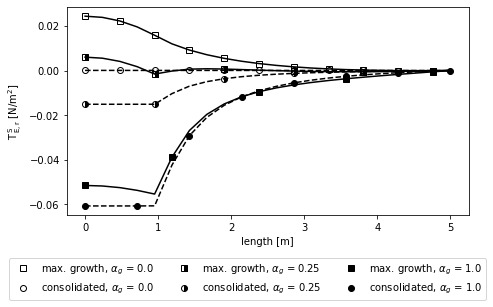

In [40]:
fig, ax = plt.subplots(figsize=(8,4.8))

ax.plot(lengths, sol_tissue_stress_path[0], color="black", label="_no_legend_")
ax.plot(lengths[::2], sol_tissue_stress_path[0][::2], linestyle="", color="black", marker='s', fillstyle = "none", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g)

ax.plot(lengths, sol_tissue_stress_path[1], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::2], sol_tissue_stress_path[1][::2], linestyle="", color="black", marker='o', fillstyle = "none", label="consolidated"  
        + r", $\alpha_g$ = " + files_tissue_outflow[0].alpha_g)


ax.plot(lengths, sol_tissue_stress_path[4], linestyle="-", color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_stress_path[4][::4], linestyle="", color="black", marker='s',fillstyle="right", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)

ax.plot(lengths, sol_tissue_stress_path[5], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::4], sol_tissue_stress_path[5][::4], linestyle="", color="black", marker='o',fillstyle="right", label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[2].alpha_g)


ax.plot(lengths, sol_tissue_stress_path[2], linestyle="-", color="black", label="_no_legend_")
ax.plot(lengths[::5], sol_tissue_stress_path[2][::5], linestyle="", color="black", marker='s',fillstyle="full", label="max. growth"  
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

ax.plot(lengths, sol_tissue_stress_path[3], linestyle="--", color="black", label="_no_legend_")
ax.plot(lengths[::3], sol_tissue_stress_path[3][::3], linestyle="", color="black", marker='o',fillstyle="full", label="consolidated" 
        + r", $\alpha_g$ = " + files_tissue_outflow[1].alpha_g)

    
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.2,box.width * 0.9, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), fancybox=True, shadow=False, ncol=3)
ax.xaxis.set_label_text('length [m]')
ax.yaxis.set_label_text(r"$\mathrm{T}^{\,\mathrm{S}}_{\,\mathrm{E,r}}$ [N/m$^2$]")
plt.savefig(sol_path + "hetero_T_S_E_path.png", dpi=600)